In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import csv
import random
from matplotlib import pyplot as plt
import math
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

import seaborn as sns 
from scipy.stats import pearsonr# This Python 3 environment comes with many helpful analytics libraries installed

In [2]:
# Import BDB 2023 Data
# Pass plays week 1-8 season 2021

games_df = pd.read_csv ('../input/nfl-big-data-bowl-2023/games.csv')
players_df = pd.read_csv ('../input/nfl-big-data-bowl-2023/players.csv')
plays_df = pd.read_csv ('../input/nfl-big-data-bowl-2023/plays.csv')
pff_df = pd.read_csv('../input/nfl-big-data-bowl-2023/pffScoutingData.csv')
weeks = []
for i in [1,2,3,4]:
    filename = '../input/nfl-big-data-bowl-2023/week'+str(i)+'.csv'
    weeks.append(pd.read_csv(filename))
weeks_df = pd.concat(weeks)

# merge scout data onto the tracking data 
weeks_df = weeks_df.merge(pff_df[['gameId', 'playId', 'nflId', 'pff_role','pff_positionLinedUp']], how='left')

# Import team color data from Lee Sharpe

teamcolors = pd.read_csv("https://raw.githubusercontent.com/leesharpe/nfldata/master/data/teamcolors.csv")

In [3]:
def data_prep(one_frame):
    meta_cols = ['gameId', 'playId', 'nflId', 'frameId']
    data_cols = ['x', 'y', 's', 'o', 'dis', 'a','pff_role']
    meta_info = one_frame[meta_cols]
    play_dir = -2*int((one_frame.iloc[0].playDirection == 'left'))+1
    df = one_frame[data_cols]
    QB = one_frame.loc[one_frame['pff_role']=='Pass'][data_cols]
    df['pff_role'] = (df['pff_role'].isin(['Pass','Pass Block'])).astype(int)
    
    arr = df.values
    xv = play_dir*np.sin(arr[:,3]*np.pi/180)*arr[:,2]
    yv = play_dir*np.cos(arr[:,3]*np.pi/180)*arr[:,2]
    arr[:,[2,3]] = np.vstack((xv,yv)).T
    arr[:,:2] = play_dir*(arr[:,:2] - QB[['x','y']].values[0])
    dists = (arr[:,0]**2 + arr[:,1]**2)**0.5
    st_arr = np.array([[-100,-100,0,0,0,0,0.5]]*12,dtype='float')
    st_arr[:len(dists)] = arr[dists.argsort()[:12]]
    
    play_info = plays_df.loc[(plays_df['gameId']==one_frame.gameId.values[0])&
                 (plays_df['playId']==one_frame.playId.values[0])]
    
    meta_feats = [one_frame['sec_since_snap'].values[0].tolist(),
                  play_info.down.values[0],
                  play_info.yardsToGo.values[0],
                  (one_frame.pff_role == 'Pass Rush').sum(),
                  (one_frame.pff_role == 'Pass Block').sum()]
    
    feat_list = meta_feats + np.concatenate(st_arr).tolist()
    target_list = one_frame['sec_til_event'].values[0]
   
    return feat_list,target_list

In [4]:
# get all plays that resulted in a sack
_sack = ['qb_sack','qb_strip_sack']
_sack_df = weeks_df.loc[weeks_df['event'].isin(_sack)]
_gpf_sack = _sack_df.groupby(['gameId','playId','frameId']).size().reset_index().drop(columns=[0])
__gpf_sack = _gpf_sack.rename(columns={'frameId':'event_frame'})
__gpf_sack = __gpf_sack.merge(plays_df[['gameId','playId','dropBackType']], how='left')
gpf_sack = __gpf_sack.loc[__gpf_sack['dropBackType']=='TRADITIONAL']

In [5]:
feats = []
target = []
for i, data in tqdm(gpf_sack.iterrows()):
    one_play = weeks_df.loc[(weeks_df['gameId']==data.gameId)&(weeks_df['playId']==data.playId)]
    one_play['sec_til_event'] = (data.event_frame - one_play.frameId)/10
    snap_fr = one_play.loc[one_play['event'].isin(['autoevent_ballsnap', 'ball_snap'])].frameId.max()
    one_play['sec_since_snap'] = (one_play.frameId - snap_fr)/10
    play_players = one_play.loc[(one_play['frameId'] >= snap_fr) &
                                (one_play['pff_role'].isin(['Pass','Pass Rush','Pass Block'])) &
                                (one_play['sec_til_event'] >= 0)& 
                                (one_play['sec_til_event'] <= 2)]
    
    if not sorted(play_players.pff_role.unique()) == sorted(['Pass','Pass Rush','Pass Block']):
            continue 
            
    for fid in play_players.frameId.unique():
        one_frame = play_players.loc[play_players['frameId']==fid]
        f,t = data_prep(one_frame)
        feats.append(f)
        target.append(t)

0it [00:00, ?it/s]

In [6]:
model = keras.Sequential([
    layers.Dense(500, activation='relu', input_shape=(89,)),
    layers.Dense(200, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(20, activation='relu'),
    layers.Dense(1),
])

model.compile(
    optimizer='adam',
    loss='mae',
)

2022-12-17 01:49:54.743200: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(np.array(feats), np.array(target), train_size=0.8, test_size=0.2,
                                                                random_state=2)

2022-12-17 01:49:54.986963: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/250
78/78 - 1s - loss: 1.1497 - val_loss: 0.4631
Epoch 2/250
78/78 - 0s - loss: 0.4949 - val_loss: 0.4873
Epoch 3/250
78/78 - 0s - loss: 0.4457 - val_loss: 0.4501
Epoch 4/250
78/78 - 0s - loss: 0.4297 - val_loss: 0.4616
Epoch 5/250
78/78 - 0s - loss: 0.3990 - val_loss: 0.3879
Epoch 6/250
78/78 - 0s - loss: 0.3577 - val_loss: 0.3381
Epoch 7/250
78/78 - 0s - loss: 0.3625 - val_loss: 0.6330
Epoch 8/250
78/78 - 0s - loss: 0.3483 - val_loss: 0.3391
Epoch 9/250
78/78 - 0s - loss: 0.3378 - val_loss: 0.3732
Epoch 10/250
78/78 - 1s - loss: 0.3035 - val_loss: 0.3318
Epoch 11/250
78/78 - 1s - loss: 0.3128 - val_loss: 0.3268
Epoch 12/250
78/78 - 0s - loss: 0.2904 - val_loss: 0.4075
Epoch 13/250
78/78 - 0s - loss: 0.2949 - val_loss: 0.3391
Epoch 14/250
78/78 - 0s - loss: 0.2857 - val_loss: 0.3030
Epoch 15/250
78/78 - 0s - loss: 0.2859 - val_loss: 0.2904
Epoch 16/250
78/78 - 0s - loss: 0.2752 - val_loss: 0.2900
Epoch 17/250
78/78 - 0s - loss: 0.2657 - val_loss: 0.3286
Epoch 18/250
78/78 - 0s

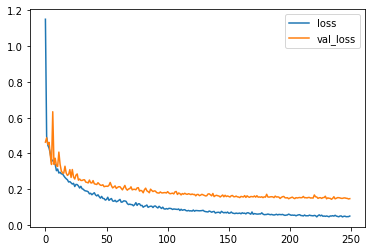

In [8]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=50,
    epochs=250,
    verbose=2,
    )

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

model.save("model_TTT_sacks_under2sec.h5")

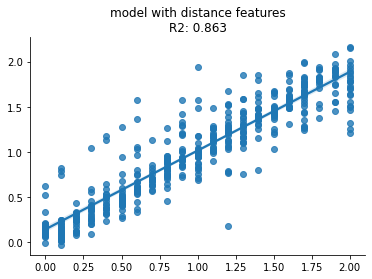

In [9]:
y_preds = model.predict(X_valid)
#y_preds = np.mean(np.mean(_y_preds,axis=2),axis=1)
#y_preds = _y_preds[:,5,0]

# calculate R2 to show explained variance
r2 = pearsonr(y_valid, y_preds)[0]**2

# plot data
sns.regplot(x=y_valid[:500], y=y_preds[:500])
plt.title(f"model with distance features\nR2: {round(r2[0], 3)}")
sns.despine()
plt.show()

In [10]:
# get all plays that resulted in a pass
_pass = ['autoevent_passforward', 'pass_forward']
_pass_df = weeks_df.loc[weeks_df['event'].isin(_pass)]
_gpf_pass = _pass_df.groupby(['gameId','playId','frameId']).size().reset_index().drop(columns=[0])
__gpf_pass = _gpf_pass.rename(columns={'frameId':'event_frame'})
__gpf_pass = __gpf_pass.merge(plays_df[['gameId','playId','dropBackType']], how='left')
gpf_pass = __gpf_pass.loc[__gpf_pass['dropBackType']=='TRADITIONAL']

In [11]:
feats = []
target = []
for i, data in tqdm(gpf_pass.iterrows()):
    one_play = weeks_df.loc[(weeks_df['gameId']==data.gameId)&(weeks_df['playId']==data.playId)]
    one_play['sec_til_event'] = (data.event_frame - one_play.frameId)/10
    snap_fr = one_play.loc[one_play['event'].isin(['autoevent_ballsnap', 'ball_snap'])].frameId.max()
    one_play['sec_since_snap'] = (one_play.frameId - snap_fr)/10
    play_players = one_play.loc[(one_play['frameId'] >= snap_fr) &
                                (one_play['pff_role'].isin(['Pass','Pass Rush','Pass Block'])) &
                                (one_play['sec_til_event'] >= 0)]
    
    if not sorted(play_players.pff_role.unique()) == sorted(['Pass','Pass Rush','Pass Block']):
            continue 
    last_frame = play_players.loc[play_players['sec_til_event']==0]
    last_f,_ = data_prep(last_frame)
    last_f = np.reshape(np.array(last_f),(1,89))
    xtra_time = model.predict(last_f)
    for fid in play_players.frameId.unique():
        #one_frame = play_players.loc[play_players['frameId']==fid]
        one_frame = play_players.loc[play_players['frameId']==fid]
        f,t = data_prep(one_frame)
        feats.append(f)
        target.append(t+xtra_time[0][0])
        

0it [00:00, ?it/s]

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(np.array(feats), np.array(target), train_size=0.8, test_size=0.2,
                                                                random_state=2)

Epoch 1/250
1069/1069 - 4s - loss: 0.4563 - val_loss: 0.4067
Epoch 2/250
1069/1069 - 4s - loss: 0.3979 - val_loss: 0.3892
Epoch 3/250
1069/1069 - 4s - loss: 0.3817 - val_loss: 0.3815
Epoch 4/250
1069/1069 - 4s - loss: 0.3699 - val_loss: 0.3785
Epoch 5/250
1069/1069 - 4s - loss: 0.3596 - val_loss: 0.3640
Epoch 6/250
1069/1069 - 4s - loss: 0.3521 - val_loss: 0.3566
Epoch 7/250
1069/1069 - 4s - loss: 0.3441 - val_loss: 0.3515
Epoch 8/250
1069/1069 - 4s - loss: 0.3374 - val_loss: 0.3612
Epoch 9/250
1069/1069 - 4s - loss: 0.3314 - val_loss: 0.3400
Epoch 10/250
1069/1069 - 4s - loss: 0.3261 - val_loss: 0.3336
Epoch 11/250
1069/1069 - 4s - loss: 0.3197 - val_loss: 0.3349
Epoch 12/250
1069/1069 - 4s - loss: 0.3152 - val_loss: 0.3243
Epoch 13/250
1069/1069 - 4s - loss: 0.3119 - val_loss: 0.3285
Epoch 14/250
1069/1069 - 4s - loss: 0.3071 - val_loss: 0.3283
Epoch 15/250
1069/1069 - 4s - loss: 0.3042 - val_loss: 0.3309
Epoch 16/250
1069/1069 - 4s - loss: 0.3003 - val_loss: 0.3217
Epoch 17/250
1069

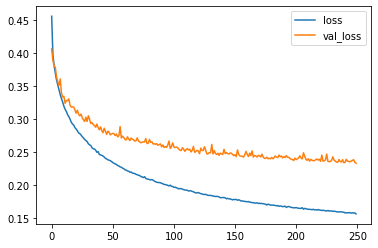

In [13]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=100,
    epochs=250,
    verbose=2,
    )

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

model.save("model_TTT_passplays.h5")

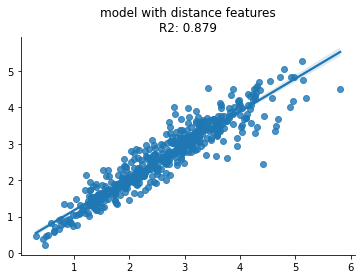

In [14]:
y_preds = model.predict(X_valid)
#y_preds = np.mean(np.mean(_y_preds,axis=2),axis=1)
#y_preds = _y_preds[:,5,0]

# calculate R2 to show explained variance
r2 = pearsonr(y_valid, y_preds)[0]**2

# plot data
sns.regplot(x=y_valid[:500], y=y_preds[:500])
plt.title(f"model with distance features\nR2: {round(r2[0], 3)}")
sns.despine()
plt.show()

(array([0.0000e+00, 1.0000e+00, 1.4700e+02, 1.3131e+04, 1.3109e+04,
        3.1100e+02, 2.0000e+01, 0.0000e+00]),
 array([-4, -3, -2, -1,  0,  1,  2,  3,  4]),
 <BarContainer object of 8 artists>)

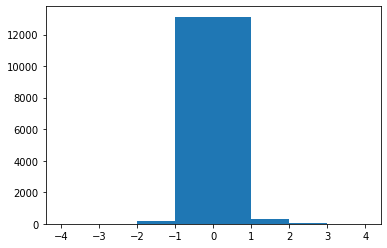

In [15]:
plt.hist(y_valid - y_preds.T[0],bins=np.arange(-4,5))